# DCGAN

DCGAN，即deep convolutional GAN的簡寫

這個範例目的是改善v1.0，依照dcgan的架構指南，有幾點建議：
1. 以步幅卷積(strided convolutions)取代所有的池化層(discriminator)，並使用微步卷積(fractional stride convolution)(generator)
2. 在Generator與Discriminator使用BatchNorm
3. 移除掉深度結構中的屬fully connected的隱藏層
4. Generator使用relu，除了最後的輸出層使用tanh
5. Discriminator都使用LeakyRelu

實務上該怎麼做還是要自己調參，個人測試以adam來跑CIFAR10這資料集還沒有成功生成過資料，但使用RMSProp是可以成功，因此即使論文建議也要依你的實務來調整，逐步測試。

## 數據集

CIFAR10為32x32x3的照片，並擁有10個輸出類別，每個類別5,000張，共計50,000張照片

## 範例說明

為了簡化範例，單純的使用一個類別做測試

這邊會著重在實作，不會有過深的理論說明

將模型訓練建置為類別操作

## 作業開始

GAN由Generator與Discriminator兩個`nn`結合而成，迭代過程大致如下說明：  
1. 初始化Generator-v1與Discriminator-v1
2. 空間中sample出一筆資料，經過Generator-v1生成
3. Discriminator-v1驗證真假，發現是假
4. Generator-v1升級為Generator-v2
5. 成功騙過Discriminator
6. Discriminator-v1升級為Discriminator-v2
7. Discriminator-v2驗證真假，發現是假
8. ....

作業開始之前定義使用的GPU資源

In [1]:
import os
# 限制gpu資源
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

首先我們建置Generator

載入需求套件

In [2]:
import keras
from keras import layers
import numpy as np
from keras.preprocessing import image

Using TensorFlow backend.


訓練模型的資料集為CIFAR10，可以由keras直接下載

首先載入處理照片需求套件

In [5]:
from keras.preprocessing import image

接著下載keras自帶的資料集，`CIFAR10`：
* 0: airplane
* 1: automobile
* 2: bird
* 3: cat
* 4: deer
* 5: dog
* 6: frog
* 7: horse
* 8: ship
* 9: truck

In [6]:
(x_train, y_train), (_, _) = keras.datasets.cifar10.load_data()

任何資料集都請務必先行驗證確認資料維度

In [7]:
x_train.shape, y_train.shape

((50000, 32, 32, 3), (50000, 1))

下載下來的照片資料，我們只會採用其中一個類別來簡化範例的進行

以`y_train.flatten() == 0`為mask來取得資料

In [8]:
x_train = x_train[y_train.flatten() == 5]

調整之後確認資料維度

In [9]:
x_train.shape

(5000, 32, 32, 3)

後面不需要太過在意`y_train`，因為對我們目前需求來說，所有真實資料皆為`Positive`

資料標準化

In [10]:
x_train = x_train / 255.

In [11]:
x_train = x_train.astype(np.float32)

前置作業完畢之後就可以正式的來訓練模型

建置類別

In [16]:
class dcgan_model:
    def __init__(self, input_shape=(32, 32, 3), laten_dim=32, lr=0.0001):
        """init 
        parameters:
            input_shape: about generator image and real image shape
            laten_dim: sample from distribution which vector's dimension
            lr: learning rate
        """
        # init hyper parameters
        self.input_shape = input_shape
        self.laten_dim = laten_dim
        self.channel = input_shape[-1]        
        self.optimizer = keras.optimizers.RMSprop(
                                        lr=0.0004,
                                        clipvalue=1.0,
                                        decay=1e-8
                                    )
        
        # init discriminator
        self.discriminator = self.discriminator_model()        
        self.discriminator.compile(loss='binary_crossentropy',
                                   optimizer=self.optimizer)
        
        self.generator = self.generator_model()
        
        # note: remember compile discriminator first.
        self.discriminator.trainable = False
        gan_input = keras.Input(shape=(self.laten_dim, ))
        gan_output = self.discriminator(self.generator(gan_input))
        self.gan = keras.models.Model(gan_input, gan_output)
        self.gan.compile(loss='binary_crossentropy',
                         optimizer=self.optimizer,)
        
        
    def generator_model(self):
        """create generator model
        function:
            sample size: 32x32x3
            sample dataset: CIFAR10

            remember use summary to check layer's dimemsion 
                or use output_shape to check output shape.

        notes:
            if you want to use tensorrt, do not use UpSampling2D, 
                it's not support yet.

        from paper:
            1. This was avoided by not applying batchnorm to the generator output layer
            2. The ReLU activation (Nair & Hinton, 2010) is used in the generator 
                with the exception of the output layer which uses the Tanh function

        parameters:
            input_dim: input vector dimension
            channel: image channel
                default:3, if binary or gray setting 1

        return:
            generator: generator model, output size is 32x32x3
        """
        generator_input = keras.Input(shape=(self.laten_dim, ))
        x = layers.Dense(128 * 16 * 16)(generator_input)
        x = layers.LeakyReLU()(x)
        x = layers.Reshape((16, 16, 128))(x)

        x = layers.Conv2D(256, 5, padding='same')(x)
        x = layers.LeakyReLU()(x)

        # 輸出為32x32
        x = layers.Conv2DTranspose(256, 4, strides=2, padding='same')(x)
        x = layers.LeakyReLU()(x)

        x = layers.Conv2D(256, 5, padding='same')(x)
        x = layers.LeakyReLU()(x)
        x = layers.Conv2D(256, 5, padding='same')(x)
        x = layers.LeakyReLU()(x)

        # 圖片channel設置為3，即輸出為32x32x3
        x = layers.Conv2D(self.channel, 7, activation='tanh', padding='same')(x)

        return keras.models.Model(generator_input, x)
    
    def discriminator_model(self):
        """create descriminator model
        function:
            sample size: 32x32x3
            sample dataset: CIFAR10

            remember use summary to check layer's dimemsion 
                or use output_shape to check output shape.

        from paper:
            1. Use LeakyReLU activation in the discriminator for all layers.
            2. This was avoided by not applying batchnorm to the discriminator input layer.
            3. In the LeakyReLU, the slope of the leak was set to 0.2 in all models.

        parameters:
            input_shape: type is HWC, tuple
                i.e. for this example is (32, 32, 3)

        return:
            discriminator: generator model, output real number. Positive or Negative.

        """
        discriminator_input = layers.Input(shape=self.input_shape)
        x = layers.Conv2D(128, 3)(discriminator_input)
        x = layers.LeakyReLU()(x)
        x = layers.Conv2D(128, 4, strides=2)(x)
        x = layers.LeakyReLU()(x)
        x = layers.Conv2D(128, 4, strides=2)(x)
        x = layers.LeakyReLU()(x)
        x = layers.Conv2D(128, 4, strides=2)(x)
        x = layers.LeakyReLU()(x)
        x = layers.Flatten()(x)
        x = layers.Dropout(0.5)(x)
        # 判斷真假，因此輸出為1個unit，並搭配sigmoid
        x = layers.Dense(1, activation='sigmoid')(x)

        return keras.models.Model(discriminator_input, x)

    
    def save_generator_img(self, generator_img, h_int, w_int, epoch, save_file_name='generator', save_dir='.'):
        """保存generator生成的照片
        function:
            利用keras自帶工具keras.preprocessing.Image保存照片

        parameters:
            generator_img: generator生成的numpy object
            h_int: 湊成一張照片的時候高要幾張
            w_ing: 湊成一張照片的時候寬要幾張
            epoch: 第幾次的迭代，保存照片的時候插入檔案名稱
            save_file_name: 檔案名稱，預設為generator
            save_dir: 保存的路徑，預設在執行程式的根目錄    

        remark:
            h_int x w_int 不能超過generator_img的長度，一定只能等於

        example:
            save_generator_img(generator_img, 4, 5, 9900)
        """
        # 取得資料維度
        N, H, W, C = generator_img.shape

        # 驗證拼湊照片數量相符
        assert int(h_int) * int(w_int) == N        

        # 開一張全zero的大陣列
        target_img = np.zeros(shape=(h_int * H, w_int * W, C))

        # 索引
        now_idx = 0    
        for h_idx in range(h_int):
            for w_idx in range(w_int):
                # 取得照片
                _img = generator_img[now_idx]
                # 取代相對應陣列位置
                target_img[h_idx * H: h_idx * H + H, w_idx * W: w_idx * W + W] = _img                        
                now_idx += 1


        file_name = os.path.join(save_dir, save_file_name + str(epoch) + '.png')
        save_img = image.array_to_img(target_img * 255., scale=False)
        save_img.save(file_name)       
    
    def train_model(self, x_train, batch_size=64, epochs=1000, save_path=None):
        """train model
        from paper:
            1. We found the suggested learning rate of 0.001, 
                to be too high, using 0.0002 instead. 
            2. Additionally, we found leaving the momentum term β1 
                at the suggested value of 0.9 resulted in training 
                oscillation and instability while reducing it to 0.5 helped 
                stabilize training.
            3. in fact, Ian train discriminator only once every epoch.

        parameters:
            x_train: training data
            batch_size: training batch_size
                default: 128, but for your gpu, maybe you need modify.
            epochs: training epochs
                default: 1000, for gan maybe need more.
            save_path: to observe generator images, maybe you want save image every n epochs
                default: none, change for your local path if you want save.            
        """   
        total_data = x_train.shape[0]
        for epoch in range(epochs):  
            # 每一次迭代都重新取得索引，以此索引取實際資料訓練
            # per epoch, re-index, then get real data.
            random_index = np.random.randint(low=0, high=total_data, size=batch_size)
            true_imgs = x_train[random_index]
            
            # 從分佈中sample一把資料
            # random sample from discribution
            random_vectors = np.random.normal(size=(batch_size, self.laten_dim))
            # 經過generator之後得到輸出為Nx32x32x3的Matrix
            # get output from generator then return Nx32x32x3 for out example
            generator_imgs = self.generator.predict(random_vectors)  

            # 將實際資料與生成資料堆疊
            # stacking ture images and generator images
            combian_imgs = np.concatenate([generator_imgs,
                                           true_imgs])
            # 實際資料標記為_0，生成資料標記為_1
            # true images label 0, generator images label 1.        
            labels = np.concatenate([np.ones((batch_size, 1)), 
                                     np.zeros((batch_size, 1))])
            
            # 對label加入噪點
            # add noise on labels
            labels += 0.05 * np.random.random(labels.shape)

            # 已取得實際、生成資料，以此資料訓練discriminator，讓它學習辨識真假資料
            # now we get generator images and true images,
            # use the combian images to trian discriminator.
            discriminator_loss = self.discriminator.train_on_batch(combian_imgs, labels)

            # 現在discriminator已知道真假資料，要更新generator
            # now discriminator know who is negative image, 
            # so we need to upgrade generator.
            # 可以重新sample，也可以用當前的生成資料
            # you can choice to resample or not. for this example i resample.
            random_vectors = np.random.normal(size=(batch_size, self.laten_dim))            
            # 要騙discriminator，因此賦給生成資料假的標記，標記為『真』
            # label for new generator images,
            # we want discriminator think all is Positive, so label is 0
            generator_labels = np.zeros((batch_size, 1))
            # 固定discriminator，單純訓練generator
            # here we fix discriminator, only train generator.            
            gan_loss = self.gan.train_on_batch(random_vectors, generator_labels)            
           
            # every 100 epochs show loss, but gan's loss ....
            if epoch % 100 == 0:
                self.gan.save_weights('gan.h5')
                print('now epoch: ', epoch)
                print('discriminator loss: ', discriminator_loss)
                print('gan loss: ', gan_loss)

                # every 100 epocs save image, if save_path not None
                if save_path:
                    self.save_generator_img(generator_imgs, 8, 8, epoch)

In [17]:
gan = dcgan_model()

In [19]:
gan.train_model(x_train=x_train, 
                batch_size=64, 
                epochs=50000, 
                save_path='/tf/GAN/DCGAN')

now epoch:  0
discriminator loss:  0.6945644
gan loss:  0.7564312
now epoch:  100
discriminator loss:  0.6905656
gan loss:  0.800822
now epoch:  200
discriminator loss:  0.70043296
gan loss:  0.7785882
now epoch:  300
discriminator loss:  0.6877709
gan loss:  0.7706368
now epoch:  400
discriminator loss:  0.72287375
gan loss:  0.8077822
now epoch:  500
discriminator loss:  0.69802713
gan loss:  0.77489483
now epoch:  600
discriminator loss:  0.7731685
gan loss:  0.8457259
now epoch:  700
discriminator loss:  0.73422974
gan loss:  0.82433325
now epoch:  800
discriminator loss:  0.70790815
gan loss:  0.7806355
now epoch:  900
discriminator loss:  0.7005171
gan loss:  0.73950773
now epoch:  1000
discriminator loss:  0.6883861
gan loss:  0.7545166
now epoch:  1100
discriminator loss:  0.69840676
gan loss:  0.761675
now epoch:  1200
discriminator loss:  0.69716036
gan loss:  0.7371433
now epoch:  1300
discriminator loss:  0.6951369
gan loss:  0.79489505
now epoch:  1400
discriminator loss: 

now epoch:  11800
discriminator loss:  0.6859546
gan loss:  0.8343008
now epoch:  11900
discriminator loss:  0.6724174
gan loss:  0.86299527
now epoch:  12000
discriminator loss:  0.7403238
gan loss:  0.99161214
now epoch:  12100
discriminator loss:  0.68267035
gan loss:  0.8680113
now epoch:  12200
discriminator loss:  0.6822002
gan loss:  0.7792303
now epoch:  12300
discriminator loss:  0.66499496
gan loss:  0.8379048
now epoch:  12400
discriminator loss:  0.66565776
gan loss:  0.7435963
now epoch:  12500
discriminator loss:  0.6777923
gan loss:  0.9250487
now epoch:  12600
discriminator loss:  1.6004862
gan loss:  12.9081955
now epoch:  12700
discriminator loss:  0.6870248
gan loss:  0.94234127
now epoch:  12800
discriminator loss:  0.67699194
gan loss:  0.7959132
now epoch:  12900
discriminator loss:  0.6682065
gan loss:  1.0366635
now epoch:  13000
discriminator loss:  0.6718503
gan loss:  0.8423262
now epoch:  13100
discriminator loss:  0.6713859
gan loss:  0.78981113
now epoch: 

now epoch:  23500
discriminator loss:  0.4106361
gan loss:  2.1708007
now epoch:  23600
discriminator loss:  0.64698327
gan loss:  1.2094421
now epoch:  23700
discriminator loss:  0.60987437
gan loss:  0.98526585
now epoch:  23800
discriminator loss:  0.6754835
gan loss:  1.0276699
now epoch:  23900
discriminator loss:  0.6460351
gan loss:  0.91745746
now epoch:  24000
discriminator loss:  0.6002181
gan loss:  0.8837216
now epoch:  24100
discriminator loss:  0.6078706
gan loss:  1.0544366
now epoch:  24200
discriminator loss:  0.60084426
gan loss:  1.0786581
now epoch:  24300
discriminator loss:  0.67699534
gan loss:  0.7520277
now epoch:  24400
discriminator loss:  0.63562834
gan loss:  0.80784
now epoch:  24500
discriminator loss:  0.6667102
gan loss:  0.876825
now epoch:  24600
discriminator loss:  0.3380897
gan loss:  2.9133162
now epoch:  24700
discriminator loss:  0.6342468
gan loss:  1.2154665
now epoch:  24800
discriminator loss:  0.53497463
gan loss:  1.2489011
now epoch:  249

now epoch:  35200
discriminator loss:  0.4002459
gan loss:  1.6020141
now epoch:  35300
discriminator loss:  0.46748286
gan loss:  1.7375522
now epoch:  35400
discriminator loss:  0.48176974
gan loss:  2.0559044
now epoch:  35500
discriminator loss:  0.54301256
gan loss:  1.4233075
now epoch:  35600
discriminator loss:  0.46378225
gan loss:  1.3402351
now epoch:  35700
discriminator loss:  0.51923394
gan loss:  0.8712225
now epoch:  35800
discriminator loss:  0.3802063
gan loss:  1.7689867
now epoch:  35900
discriminator loss:  0.4149507
gan loss:  1.3880789
now epoch:  36000
discriminator loss:  0.3208606
gan loss:  2.5167994
now epoch:  36100
discriminator loss:  0.45269355
gan loss:  1.3432076
now epoch:  36200
discriminator loss:  0.45955896
gan loss:  1.3873749
now epoch:  36300
discriminator loss:  0.5684327
gan loss:  1.0337406
now epoch:  36400
discriminator loss:  0.36200804
gan loss:  1.8221045
now epoch:  36500
discriminator loss:  0.5458792
gan loss:  1.6598747
now epoch:  

now epoch:  46900
discriminator loss:  -0.03502927
gan loss:  9.618074
now epoch:  47000
discriminator loss:  0.2216848
gan loss:  3.1219835
now epoch:  47100
discriminator loss:  0.32231808
gan loss:  2.5338185
now epoch:  47200
discriminator loss:  0.4269332
gan loss:  1.7164845
now epoch:  47300
discriminator loss:  0.08858868
gan loss:  7.7733555
now epoch:  47400
discriminator loss:  0.037449963
gan loss:  11.361797
now epoch:  47500
discriminator loss:  0.39270762
gan loss:  5.07437
now epoch:  47600
discriminator loss:  0.2559747
gan loss:  3.1263223
now epoch:  47700
discriminator loss:  0.35410357
gan loss:  1.9284797
now epoch:  47800
discriminator loss:  0.23120645
gan loss:  2.5985236
now epoch:  47900
discriminator loss:  0.61463404
gan loss:  5.256847
now epoch:  48000
discriminator loss:  0.19087929
gan loss:  9.559304
now epoch:  48100
discriminator loss:  0.11634448
gan loss:  6.8609605
now epoch:  48200
discriminator loss:  0.29872155
gan loss:  3.1407745
now epoch:  

## 確認生成照片

In [20]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline

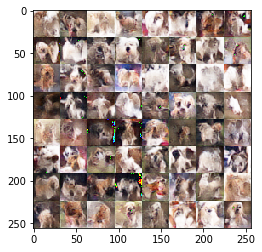

In [26]:
img_path = 'generator49600.png'
gen_img = mpimg.imread(img_path)
plt.imshow(gen_img)

## 結論

一個很重要的設置是，discriminator=False一定要在discriminator.compile之後執行，因為compile之後的模型是無法再被修正的，因此在將discriminator與generator結合的時候，雖然調整了discriminator=False，但這個flag只會帶到結合的模型-gan之中，而不影響原始的discriminator。